In [1]:
%config InlineBackend.figure_formats = ['svg']
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [10]:
from model.layers import NestedDropout, SNLinearCombo, _Combo
from model.cmpnts import MLP, SNMLP, LasagnaMLP
from model.layers import SNLinearCombo
from torch.linalg import svd

# 2D
## 1D Manifold

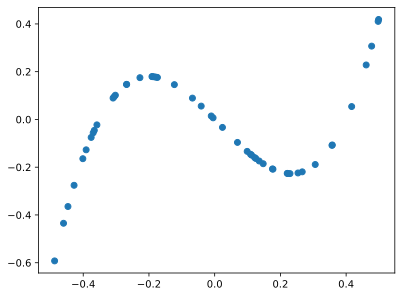

In [3]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
# Y = X + 5 * X ** 3 
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [29]:
from torch.nn.utils.parametrizations import spectral_norm
class SNLinearCombo(_Combo):
    r"""Regular fully connected layer combo.
    """
    def __init__(self, in_features, out_features, alpha=0.2):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(in_features, out_features)),
            nn.SiLU()
        )

class LasagnaMLP(SNMLP):
    def __init__(self, in_features: int, out_features: int, layer_width: list, combo=SNLinearCombo):
        super().__init__(in_features, out_features, layer_width, combo) # type: ignore
        self._log = nn.Parameter(torch.zeros(len(self.model) - 1))

    def forward(self, x):
        for l, f in zip(self._log, self.model[:-1]):
            x = f(torch.exp(l) * x)
        l = - self._log.sum()
        return self.model[-1](1.5 * torch.exp(l) * x)

In [30]:
data = torch.stack([X, Y], dim=-1).to('cuda:0')

encoder = LasagnaMLP(2, 1, [32]*4).to('cuda:0')
decoder = LasagnaMLP(1, 2, [32]*4).to('cuda:0')
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    # vol_loss = torch.exp(torch.log(z.std(0)).mean())
    loss = rec_loss #+ 0.001 * vol_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}'.format(i, rec_loss))

Epoch 0: rec = 0.07045058906078339
Epoch 100: rec = 0.06222136691212654
Epoch 200: rec = 0.0313495434820652
Epoch 300: rec = 0.019889188930392265
Epoch 400: rec = 0.019666094332933426
Epoch 500: rec = 0.019606173038482666
Epoch 600: rec = 0.019699763506650925
Epoch 700: rec = 0.01953316293656826
Epoch 800: rec = 0.02020217850804329
Epoch 900: rec = 0.01950680837035179
Epoch 1000: rec = 0.01949457824230194
Epoch 1100: rec = 0.019484663382172585
Epoch 1200: rec = 0.019476842135190964
Epoch 1300: rec = 0.019471006467938423
Epoch 1400: rec = 0.01954907551407814
Epoch 1500: rec = 0.019461805000901222
Epoch 1600: rec = 0.019456449896097183
Epoch 1700: rec = 0.01945137046277523
Epoch 1800: rec = 0.019447512924671173
Epoch 1900: rec = 0.01944248378276825
Epoch 2000: rec = 0.01943729631602764
Epoch 2100: rec = 0.019432570785284042
Epoch 2200: rec = 0.01942770928144455
Epoch 2300: rec = 0.019420793280005455
Epoch 2400: rec = 0.0194125697016716
Epoch 2500: rec = 0.019403601065278053
Epoch 2600: r

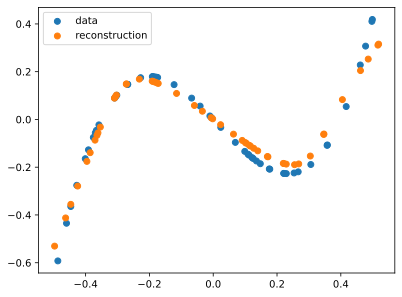

In [31]:
rec = decoder(z).cpu().detach().numpy()
plt.scatter(X.numpy(), Y.numpy(), label='data')
plt.scatter(rec[:, 0], rec[:, 1], label='reconstruction')
plt.legend()

In [32]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.cpu().numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

/opt/conda/conda-bld/pytorch_1678402411778/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [0,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1678402411778/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [1,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
